In [1]:
!pip install opendatasets
import opendatasets as od # gorserkaggle ba5ff663ab4a658f9e1fba7e39ce2c56
# https://www.kaggle.com/competitions/classification-of-butterflies/submissions
od.download("https://www.kaggle.com/competitions/classification-of-butterflies/overview")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gorserkaggle
Your Kaggle Key: ··········


100%|██████████| 132M/132M [00:01<00:00, 130MB/s]



Extracting archive ./classification-of-butterflies/classification-of-butterflies.zip to ./classification-of-butterflies


In [4]:
from sklearn.exceptions import ConvergenceWarning
import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

from tqdm import tqdm

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the directory containing the image dataset
train_path = '/content/classification-of-butterflies/train_butterflies/train_split'

# Create an ImageDataGenerator for augmenting the dataset
train = {
    'imgpath': [],
    'labels': []
}

for category in tqdm(os.listdir(train_path)):
  label = category.replace('class_', '')
  for file in os.listdir(f'{train_path}/{category}'):
    train['imgpath'].append(
        f'{train_path}/{category}/{file}'
    )
    train['labels'].append(label)

df = pd.DataFrame(train)

train_df = df.sample(frac=0.8, random_state=1)
valid_df = df.drop(train_df.index)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
)

# Create the image dataset from the directory
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size= 25,
    shuffle=True,
    seed=42,
)



100%|██████████| 50/50 [00:00<00:00, 7553.49it/s]

Found 3964 validated image filenames belonging to 50 classes.


In [14]:
valid_df

,imgpath,labels
2,/content/classification-of-butterflies/train_b...,34
9,/content/classification-of-butterflies/train_b...,34
14,/content/classification-of-butterflies/train_b...,34
15,/content/classification-of-butterflies/train_b...,34
18,/content/classification-of-butterflies/train_b...,34
...,...,...
4937,/content/classification-of-butterflies/train_b...,35
4940,/content/classification-of-butterflies/train_b...,35
4943,/content/classification-of-butterflies/train_b...,35
4946,/content/classification-of-butterflies/train_b...,35


In [15]:
generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
)

valid = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size= 25,
    shuffle=True,
    seed=42,
)



Found 991 validated image filenames belonging to 50 classes.


In [16]:
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.13),
  layers.experimental.preprocessing.RandomZoom(0.12),
  layers.experimental.preprocessing.RandomContrast(0.10),
], name='AugmentationLayer')

inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024

In [19]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    epochs=10,
    validation_data=(valid),
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

Epoch 1/10
159/159 [==============================] - 27s 80ms/step - loss: 2.2115 - accuracy: 0.4556 - val_loss: 0.9669 - val_accuracy: 0.7467 - lr: 5.0000e-04
Epoch 2/10
159/159 [==============================] - 10s 62ms/step - loss: 0.8853 - accuracy: 0.7730 - val_loss: 0.5736 - val_accuracy: 0.8708 - lr: 5.0000e-04
Epoch 3/10
159/159 [==============================] - 10s 62ms/step - loss: 0.5846 - accuracy: 0.8527 - val_loss: 0.4773 - val_accuracy: 0.8840 - lr: 5.0000e-04
Epoch 4/10
159/159 [==============================] - 10s 62ms/step - loss: 0.4369 - accuracy: 0.8946 - val_loss: 0.4236 - val_accuracy: 0.8860 - lr: 5.0000e-04
Epoch 5/10
159/159 [==============================] - 11s 68ms/step - loss: 0.3786 - accuracy: 0.9019 - val_loss: 0.4330 - val_accuracy: 0.8900 - lr: 5.0000e-04
Epoch 6/10
159/159 [==============================] - 9s 57ms/step - loss: 0.3250 - accuracy: 0.9170 - val_loss: 0.4780 - val_accuracy: 0.8638 - lr: 5.0000e-04
Epoch 7/10
159/159 [===============

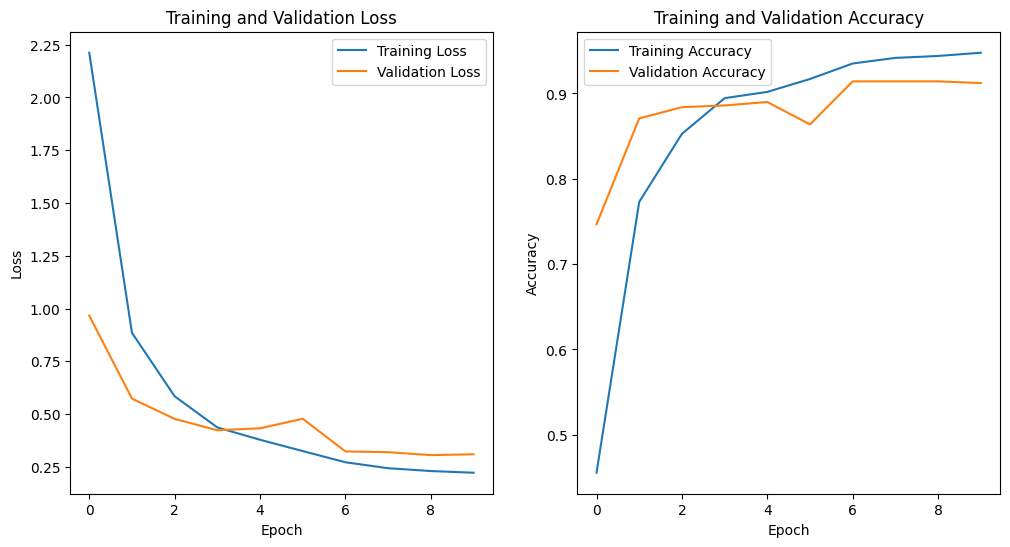

In [20]:
import matplotlib.pyplot as plt

# Получаем значения потерь для обучающей и валидационной выборок
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Получаем значения точности для обучающей и валидационной выборок
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Строим график потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Строим график точности
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Отображаем графики
plt.show()


# Использованые инструменты
Использована модель EfficientNetB0 которая была обучена на большом объеме данных и позволяет получить высокие метрики. Она является сверточной

Сверточные нейронные сети - это тип нейронных сетей, специально разработанных для обработки данных изображений. Они используют операцию свертки для обнаружения различных признаков изображений на разных уровнях абстракции.

Операция свертки или как работают светрочные нейросети - на изображение накладывается фильтр где перемножаются и суммируются все элементы, таким образом формируется итоговая матрица меньшего размера. Фильтр имеет туже размерность что и глубина изображения (Если оно трех канальное, то и фильтр трехмерный)

In [73]:
test_path = '/content/classification-of-butterflies/test_butterflies/valid'

test = {
    'img': [],
    'index': []
}

for file in os.listdir(test_path):
    img = cv2.imread(f'{test_path}/{file}')
    test['img'].append(
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    )
    test['index'].append(int(file.replace('.jpg', '')))

test = {
    'img': np.array(test['img']),
    'index': np.array(test['index'])
}

preds = model.predict(test['img'], verbose=1)
preds

8/8 [==============================] - 0s 43ms/step


array([[3.6369324e-06, 8.3670195e-05, 6.9219345e-06, ..., 7.8065394e-05,
        8.6651098e-06, 2.2368840e-05],
       [4.1527596e-08, 6.3890559e-07, 2.1713209e-08, ..., 2.4348669e-06,
        1.0485593e-04, 3.2104414e-05],
       [2.5982442e-07, 9.8469893e-05, 8.0435302e-06, ..., 1.0356853e-06,
        9.3411691e-05, 9.4512790e-05],
       ...,
       [2.1198975e-08, 2.8472230e-06, 3.3280627e-09, ..., 1.1756516e-06,
        2.6265805e-05, 9.7303811e-05],
       [5.6843936e-07, 1.6101128e-05, 4.8367965e-06, ..., 9.9749322e-08,
        2.7025100e-03, 2.0148007e-06],
       [1.5874472e-04, 1.1568733e-04, 1.1223757e-04, ..., 3.9104158e-03,
        8.1886764e-04, 7.6887943e-04]], dtype=float32)

In [102]:
preds.shape

(250, 50)

In [130]:
class_names = train_images.class_indices
class_names

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '3': 23,
 '30': 24,
 '31': 25,
 '32': 26,
 '33': 27,
 '34': 28,
 '35': 29,
 '36': 30,
 '37': 31,
 '38': 32,
 '39': 33,
 '4': 34,
 '40': 35,
 '41': 36,
 '42': 37,
 '43': 38,
 '44': 39,
 '45': 40,
 '46': 41,
 '47': 42,
 '48': 43,
 '49': 44,
 '5': 45,
 '6': 46,
 '7': 47,
 '8': 48,
 '9': 49}

In [135]:
inv_map = {v: k for k, v in class_names.items()}
inv_map

{0: '0',
 1: '1',
 2: '10',
 3: '11',
 4: '12',
 5: '13',
 6: '14',
 7: '15',
 8: '16',
 9: '17',
 10: '18',
 11: '19',
 12: '2',
 13: '20',
 14: '21',
 15: '22',
 16: '23',
 17: '24',
 18: '25',
 19: '26',
 20: '27',
 21: '28',
 22: '29',
 23: '3',
 24: '30',
 25: '31',
 26: '32',
 27: '33',
 28: '34',
 29: '35',
 30: '36',
 31: '37',
 32: '38',
 33: '39',
 34: '4',
 35: '40',
 36: '41',
 37: '42',
 38: '43',
 39: '44',
 40: '45',
 41: '46',
 42: '47',
 43: '48',
 44: '49',
 45: '5',
 46: '6',
 47: '7',
 48: '8',
 49: '9'}

In [136]:
inv_map[9]

'17'

In [138]:
import numpy as np

ypred = []
for i, p in enumerate(preds):
    index = np.argmax(p)
    klass = inv_map[index]
    ypred.append(int(klass))

ypred = np.array(ypred)
ypred

array([20,  3, 34, 39, 23, 41, 10, 32,  3, 23, 47, 39, 48, 14, 19, 17, 36,
        7,  3, 16,  0, 33, 48, 25, 24, 12,  6, 24, 10, 26, 32, 26,  9, 31,
        8, 19, 30,  4, 15, 48,  6, 23, 35, 42,  0, 22, 40, 41, 31, 34,  6,
       46, 18, 29, 26, 43,  2, 32, 25, 48, 31, 32, 36, 16, 37,  5, 31, 47,
       19, 46, 49, 18,  5, 25, 19,  2, 43, 22, 47, 33,  9, 20, 28, 12, 21,
        0, 43, 11, 12,  5, 13, 46, 38, 12,  0, 46, 20, 49, 31, 41,  6, 27,
       36, 34, 21, 28, 14, 14, 33, 42, 41, 27, 20, 14, 44,  7, 30, 28, 18,
       22, 35, 41, 13,  8, 26, 15, 36, 21, 22, 40, 17, 24,  9,  7, 30, 38,
       15, 38, 25,  4, 44, 45, 23, 43, 23, 28, 36, 16, 21, 16, 41, 17,  2,
       26, 23, 27, 11, 40,  1, 35,  4, 13, 45, 32,  8, 24, 33, 39, 11,  2,
       18,  7,  8,  4, 24, 28,  3, 29,  4,  9, 15, 23, 38, 21, 39, 49, 25,
       48,  1, 44, 37, 35,  1, 16,  1, 44, 12,  9, 10,  7, 47, 39, 13, 29,
        9, 37, 33, 37, 14, 17, 15,  6,  5, 40,  5,  1, 27, 42, 29, 47, 18,
       40,  1,  0, 48, 28

In [139]:
import numpy as np

ypred = np.array(ypred)
df = pd.DataFrame(ypred, columns=['label'])
#df['label'] = df['label'].str.replace("class_",'')
df['label'] = df['label'].astype(int)
df = df.reset_index()
df['index'] = test['index']

from google.colab import files

df.to_csv('predictions.csv', index=False)
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [140]:
df

,index,label
0,191,20
1,169,3
2,15,34
3,59,39
4,213,23
...,...,...
245,106,8
246,111,10
247,144,3
248,132,37


*{"username":"gorserkaggle","key":"ba5ff663ab4a658f9e1fba7e39ce2c56"}*